In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\sflan\AppData\Local\Temp\ipykernel_19108\3548685118.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-01-01", progress=False)



Data Download Complete!
Shape of Returns Matrix: (741, 16)

Last 5 Days of Returns:
Ticker          AAPL       AMD      AMZN       APH       CEG      EQIX  \
Date                                                                     
2024-12-24  0.011413  0.013472  0.017573  0.009394  0.006593  0.011029   
2024-12-26  0.003171 -0.009787 -0.008770 -0.001397 -0.005017 -0.001707   
2024-12-27 -0.013331  0.001039 -0.014641 -0.011525 -0.009227 -0.006060   
2024-12-30 -0.013352 -0.022211 -0.011010 -0.017685 -0.000972 -0.007165   
2024-12-31 -0.007083 -0.013568 -0.008668 -0.000720 -0.011599  0.007409   

Ticker           ETN     GOOGL      META      MSFT        MU      NVDA  \
Date                                                                     
2024-12-24  0.011277  0.007575  0.013084  0.009330 -0.004916  0.003930   
2024-12-26 -0.004049 -0.002604 -0.007266 -0.002781  0.006030 -0.002070   
2024-12-27 -0.016391 -0.014626 -0.005885 -0.017453 -0.013337 -0.021088   
2024-12-30 -0.006747 -0.00

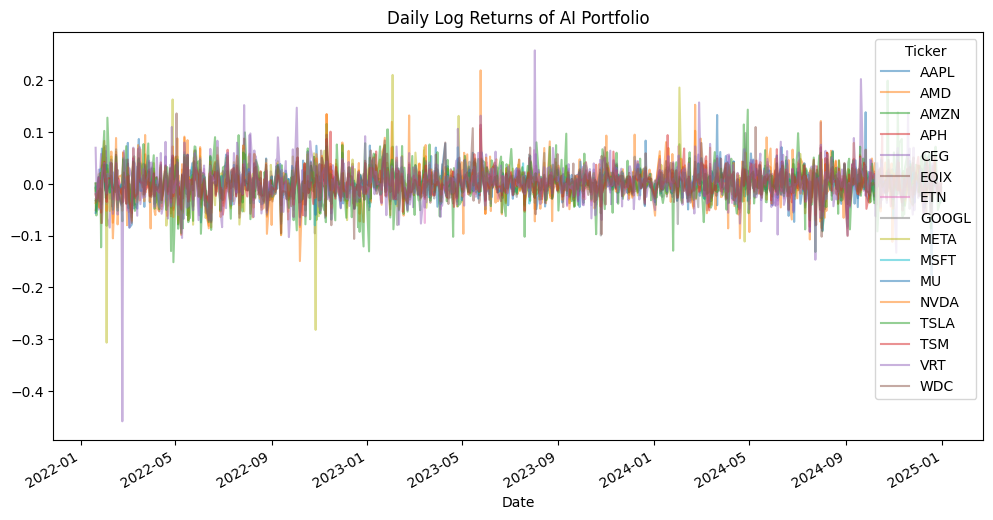

In [3]:
# 1. Define the "AI Infrastructure" Portfolio
# We group them to stay organized, but we will pass a flat list to yfinance
tickers = [
    # Semis (The Brains)
    "NVDA", "TSM", "AMD",
    # Memory (The Storage)
    "MU", "WDC",
    # Infrastructure/Cooling (The Body)
    "VRT", "APH", "EQIX",
    # Energy (The Power)
    "CEG", "ETN",
    # Mag 7 (The Customers) - excluding NVDA since it's in Semis
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA"
]

# 2. Download Data (Last 5 Years)
print(f"Downloading data for {len(tickers)} tickers...")
data = yf.download(tickers, start="2020-01-01", end="2025-01-01", progress=False)

# YF now automatically provides Adj Close
prices = data['Close']

# 4. Calculate Logarithmic Returns using NumPy
# Formula: ln(Price_t / Price_t-1)
# Why Log Returns? They are time-additive, making them mathematically superior for
# the Monte Carlo simulations we will do later.
log_returns = np.log(prices / prices.shift(1))

# 5. Data Cleaning (Pandas)
# Drop the first row (NaN) created by the shift operation
log_returns = log_returns.dropna()

# 6. Basic Sanity Check
print("\nData Download Complete!")
print(f"Shape of Returns Matrix: {log_returns.shape}")
print("\nLast 5 Days of Returns:")
print(log_returns.tail())

# Optional: Quick Visualization to check for bad data
log_returns.plot(figsize=(12, 6), title="Daily Log Returns of AI Portfolio", alpha=0.5)
plt.show()

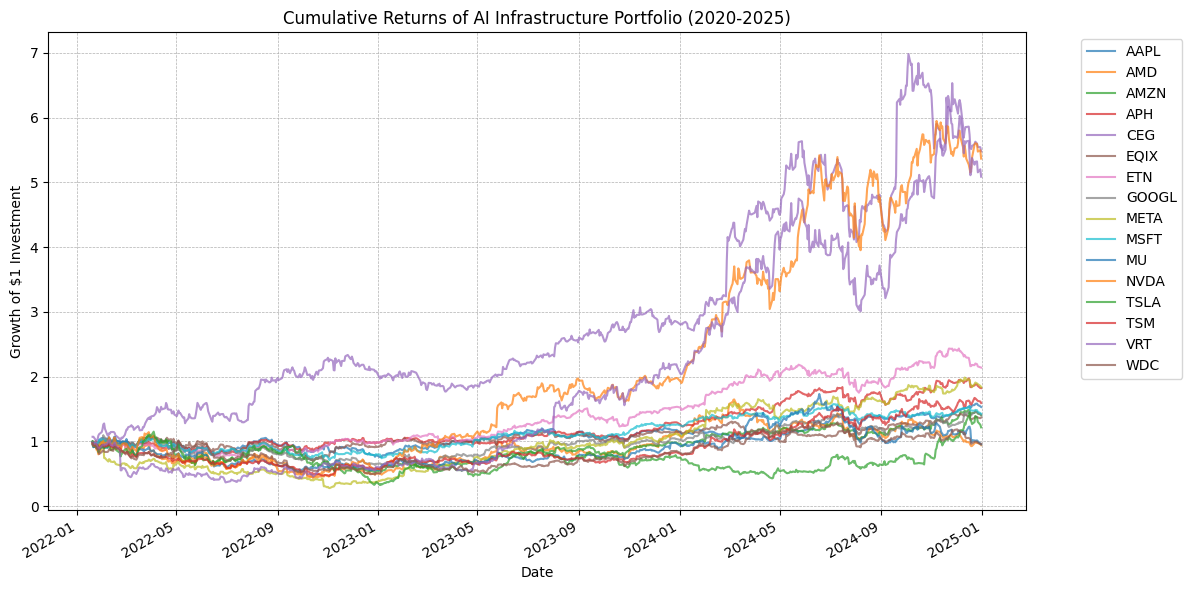

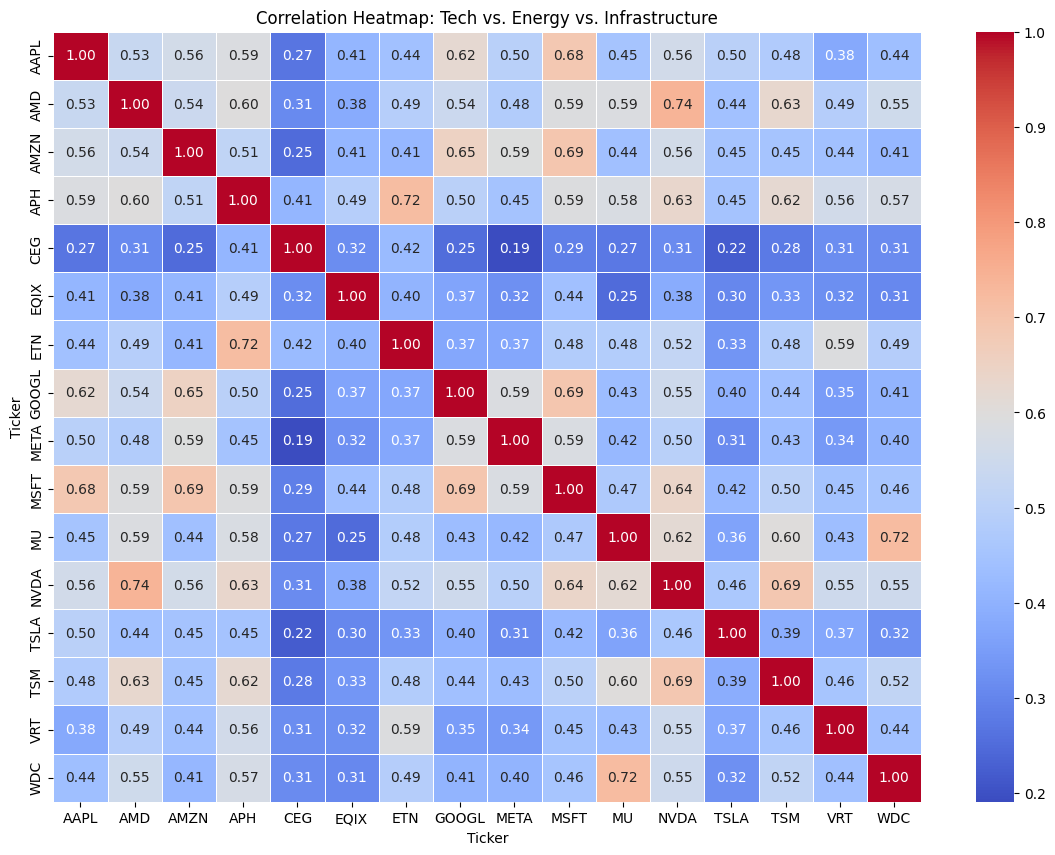


Annualized Covariance Matrix (First 5x5 view):
Ticker      AAPL       AMD      AMZN       APH       CEG
Ticker                                                  
AAPL    0.073299  0.075950  0.058675  0.040466  0.031347
AMD     0.075950  0.275143  0.109752  0.079449  0.070227
AMZN    0.058675  0.109752  0.148309  0.050261  0.041512
APH     0.040466  0.079449  0.050261  0.064617  0.044885
CEG     0.031347  0.070227  0.041512  0.044885  0.185444


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- A. Visualizing Growth (The "Eye Test") ---
# We calculate Cumulative Returns to see how the portfolio components have performed.
# Formula: Cumulative Return = exp(cumsum(log_returns))
cumulative_returns = log_returns.cumsum().apply(np.exp)

plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca(), linewidth=1.5, alpha=0.7)
plt.title("Cumulative Returns of AI Infrastructure Portfolio (2020-2025)")
plt.ylabel("Growth of $1 Investment")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Moves legend outside
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- B. The Correlation Matrix (Testing Your Thesis) ---
# This proves if your 'Energy' stocks actually provide diversification from 'Tech'.
correlation_matrix = log_returns.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Tech vs. Energy vs. Infrastructure")
plt.show()

# --- C. The Covariance Matrix (The Monte Carlo Engine) ---
# This is the most critical math output. It represents the volatility and risk.
# We multiply by 252 to "Annualize" the risk (252 trading days in a year).
covariance_matrix = log_returns.cov() * 252

print("\nAnnualized Covariance Matrix (First 5x5 view):")
print(covariance_matrix.iloc[:5, :5])

Expected Annual Return: 19.70%
Annualized Volatility:  28.83%

--- RISK ANALYSIS (95% Confidence) ---
Initial Investment: $1,000,000.00
Mean Ending Value:  $1,212,767.18
Worst Case (5th %): $726,142.71
Value at Risk (VaR): $273,857.29
Interpretation: We are 95% confident that your loss over 1 year will NOT exceed this amount.


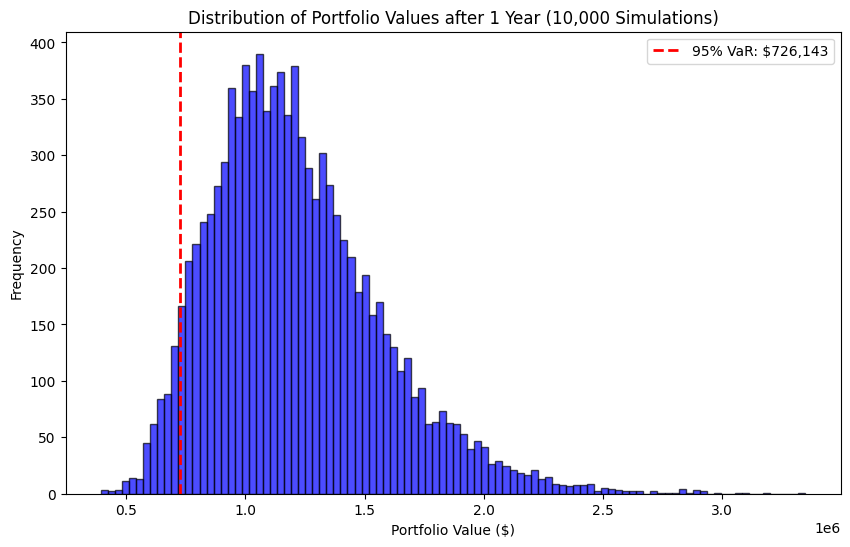

In [9]:
# --- 1. Portfolio Construction (The Weights) ---
# We have 14 tickers. Let's assume an EQUAL WEIGHT portfolio for now.
# (You can customize this later to be heavier on NVDA/Energy if you want).
num_assets = len(tickers)
weights = np.array([1/num_assets] * num_assets)

# --- 2. Portfolio Statistics (Linear Algebra) ---
# Calculate expected portfolio return and volatility using Matrix Algebra.
# This is the "Bridge Proof" math: Volatility = sqrt(Weights_Transposed * Covariance * Weights)

# Annualize mean returns (252 days)
port_mean_return = np.sum(log_returns.mean() * weights) * 252

# Annualize Portfolio Volatility
# Logic: w.T @ Sigma @ w
port_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

print(f"Expected Annual Return: {port_mean_return:.2%}")
print(f"Annualized Volatility:  {port_volatility:.2%}")

# --- 3. The Simulation (Monte Carlo) ---
# Setup
T = 1.0           # Time horizon in years (1 year)
days = 215        # Trading days in a year
dt = T / days     # Time step
simulations = 10000 # Number of parallel universes

# Initial Investment
initial_portfolio_value = 1000000 # $1,000,000 invested

# Pre-allocate the simulation matrix (10,000 simulations x 252 days)
# We simulate the PORTFOLIO value directly using the portfolio statistics calculated above.
portfolio_sims = np.zeros((days, simulations))
portfolio_sims[0] = initial_portfolio_value

# Loop through each day (vectorized across all 10,000 simulations)
for t in range(1, days):
    # Random Shock (Z score) from Normal Distribution
    Z = np.random.normal(0, 1, simulations)
    
    # Geometric Brownian Motion Formula:
    # New_Price = Old_Price * exp( (Mean - 0.5 * Vol^2)*dt + Vol * sqrt(dt) * Z )
    drift = (port_mean_return - 0.5 * port_volatility**2) * dt
    shock = port_volatility * np.sqrt(dt) * Z
    
    # Update current day's value based on previous day
    portfolio_sims[t] = portfolio_sims[t-1] * np.exp(drift + shock)

# --- 4. Value at Risk (VaR) Analysis ---
# Get the final ending value for all 10,000 simulations
final_values = portfolio_sims[-1]

# Calculate the 95% VaR
# We look for the value at the 5th percentile (the worst 5% of outcomes)
var_95_percentile = np.percentile(final_values, 5)
var_95_amount = initial_portfolio_value - var_95_percentile

print("\n--- RISK ANALYSIS (95% Confidence) ---")
print(f"Initial Investment: ${initial_portfolio_value:,.2f}")
print(f"Mean Ending Value:  ${np.mean(final_values):,.2f}")
print(f"Worst Case (5th %): ${var_95_percentile:,.2f}")
print(f"Value at Risk (VaR): ${var_95_amount:,.2f}")
print("Interpretation: We are 95% confident that your loss over 1 year will NOT exceed this amount.")

# --- 5. Visualization ---
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(var_95_percentile, color='red', linestyle='dashed', linewidth=2, label=f'95% VaR: ${var_95_percentile:,.0f}')
plt.title("Distribution of Portfolio Values after 1 Year (10,000 Simulations)")
plt.xlabel("Portfolio Value ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Simulating risk landscape...


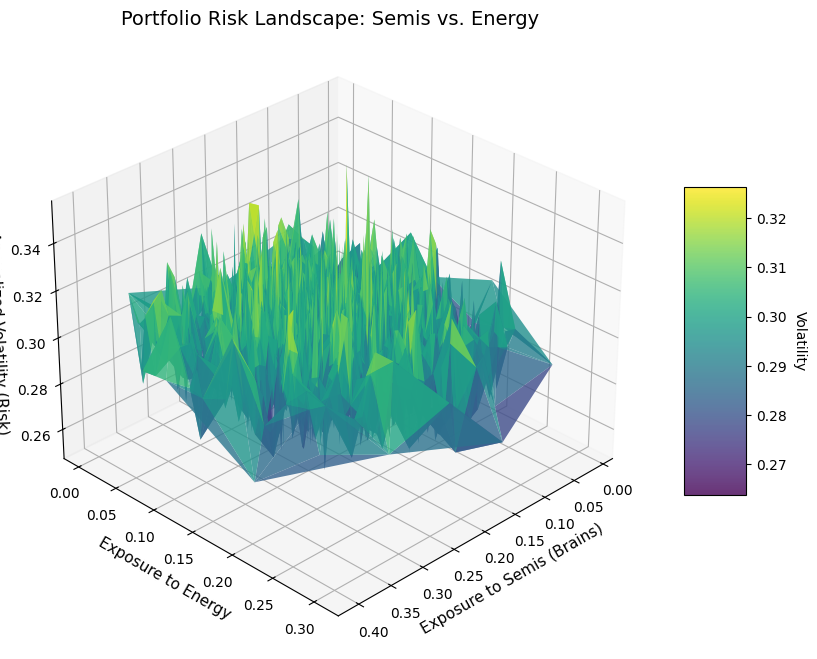

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Define Sectors for Analysis ---
# We want to see how these two specific sectors drive volatility
sector_map = {
    'Brains': ['NVDA', 'TSM', 'AMD'],
    'Energy': ['CEG', 'ETN']
}

# Helper to get indices for these sectors
brains_indices = [tickers.index(t) for t in sector_map['Brains']]
energy_indices = [tickers.index(t) for t in sector_map['Energy']]

# --- 2. Run a Targeted Simulation (5,000 Portfolios) ---
n_points = 5000
results_brains_weight = []
results_energy_weight = []
results_volatility = []

print("Simulating risk landscape...")

for _ in range(n_points):
    # Generate random weights
    w = np.random.random(len(tickers))
    w /= np.sum(w) # Normalize to sum to 1
    
    # Calculate Portfolio Volatility for this random mix
    # Vol = sqrt(w.T @ Sigma @ w)
    vol = np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w)))
    
    # Store the specific sector weights and the resulting vol
    results_brains_weight.append(np.sum(w[brains_indices]))
    results_energy_weight.append(np.sum(w[energy_indices]))
    results_volatility.append(vol)

# --- 3. Plotting the 3D Surface ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
# X = Brains Exposure, Y = Energy Exposure, Z = Risk (Volatility)
surf = ax.plot_trisurf(results_brains_weight, 
                       results_energy_weight, 
                       results_volatility, 
                       cmap='viridis', 
                       edgecolor='none', 
                       alpha=0.8)

# Labels
ax.set_title('Portfolio Risk Landscape: Semis vs. Energy', fontsize=14)
ax.set_xlabel('Exposure to Semis (Brains)', fontsize=11)
ax.set_ylabel('Exposure to Energy', fontsize=11)
ax.set_zlabel('Annualized Volatility (Risk)', fontsize=11)

# Add a color bar to show the Volatility levels
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Volatility', rotation=270, labelpad=15)

# View Angle (Adjust these to rotate the plot!)
ax.view_init(elev=30, azim=45)

plt.show()